Iniciando la generación del gráfico de fronteras de decisión k-NN...

--- 1. Cargando y preparando datos ---
Datos listos. Clases (Continentes) encontradas: ['Eastern Mediterranean' 'Europe' 'Africa' 'Americas' 'Western Pacific'
 'South-East Asia']

--- 2. Preparando el modelo k-NN ---

--- 3. Entrenando k-NN y generando la malla de decisión ---

--- 4. Generando el gráfico ---


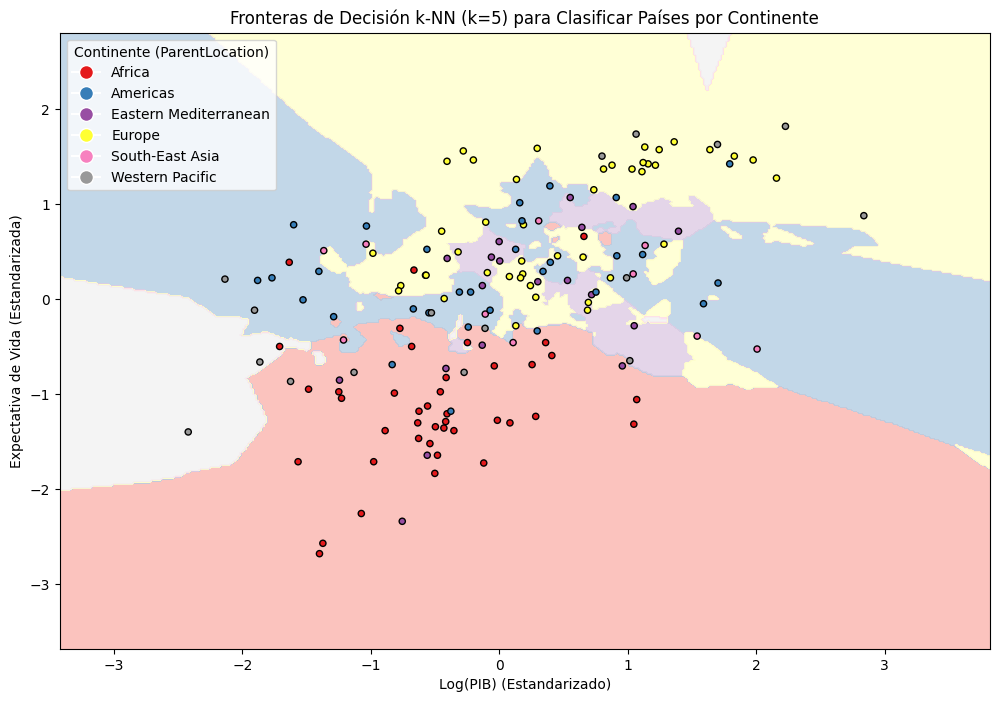

Gráfico k-NN guardado en 'knn_decision_boundary.png'


<Figure size 640x480 with 0 Axes>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from matplotlib.colors import ListedColormap

print("Iniciando la generación del gráfico de fronteras de decisión k-NN...")

try:
    # --- Tarea 1: Carga y Preparación de Datos para Clasificación ---
    print("\n--- 1. Cargando y preparando datos ---")
    
    # 1.1 Cargar y limpiar datos del PIB (PIB)
    pib_df = pd.read_csv("data_2025/pib2020-2025.csv")
    pib_df['2021_numeric'] = pd.to_numeric(pib_df['2021'], errors='coerce')
    gdp_2021 = pib_df[['Country', '2021_numeric']].rename(columns={'2021_numeric': 'GDP_2021'})
    gdp_2021 = gdp_2021.dropna()

    # 1.2 Cargar y limpiar datos de Expectativa de Vida (WHO)
    # Esta vez, también extraeremos 'ParentLocation' (el continente)
    who_df = pd.read_csv("data_2025/WHO_life_expectancy.csv")
    who_df['Life_Expectancy'] = who_df['Value'].astype(str).str.extract(r"(\d+\.?\d*)").astype(float)
    
    who_df_filtered = who_df[
        (who_df['Indicator'] == 'Life expectancy at birth (years)') &
        (who_df['Dim1'] == 'Both sexes') &
        (who_df['Period'] == 2021)
    ]
    
    # Seleccionamos las columnas que necesitamos, incluyendo 'ParentLocation'
    who_data_2021 = who_df_filtered[['Location', 'Life_Expectancy', 'ParentLocation']].rename(columns={'Location': 'Country'})
    who_data_2021 = who_data_2021.dropna()

    # 1.3 Unir los DataFrames
    merged_df = pd.merge(gdp_2021, who_data_2021, on='Country', how='inner')
    
    # Filtrar GDP > 0 para poder aplicar el logaritmo
    merged_df = merged_df[merged_df['GDP_2021'] > 0]
    # Usamos Log(PIB) como feature, ya que está mejor distribuido
    merged_df['Log_GDP'] = np.log(merged_df['GDP_2021'])
    
    # DataFrame final para el modelo
    final_data = merged_df[['Log_GDP', 'Life_Expectancy', 'ParentLocation']].dropna()
    print(f"Datos listos. Clases (Continentes) encontradas: {final_data['ParentLocation'].unique()}")

    # --- Tarea 2: Preparación del Modelo k-NN ---
    print("\n--- 2. Preparando el modelo k-NN ---")
    
    # X: Features (Características). Usamos Log(PIB) y Exp. de Vida
    X = final_data[['Log_GDP', 'Life_Expectancy']]
    
    # y: Target (Clase). Usamos el Continente
    y_labels = final_data['ParentLocation']
    
    # k-NN necesita que las clases 'y' sean numéricas (0, 1, 2...)
    le = LabelEncoder()
    y = le.fit_transform(y_labels)
    
    # Es crucial estandarizar (escalar) las features para k-NN
    # Esto asegura que Log(PIB) y Exp. de Vida tengan la misma importancia
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # --- Tarea 3: Entrenamiento del Modelo y Creación de la Malla ---
    print("\n--- 3. Entrenando k-NN y generando la malla de decisión ---")
    
    # Definimos k (número de vecinos)
    k = 5
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_scaled, y)
    
    # Crear una malla de puntos para graficar las fronteras
    h = .02 # tamaño de la celda de la malla
    x_min, x_max = X_scaled[:, 0].min() - 1, X_scaled[:, 0].max() + 1
    y_min, y_max = X_scaled[:, 1].min() - 1, X_scaled[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Predecir la clase para cada punto en la malla
    # np.c_ toma las mallas xx e yy y las convierte en pares de coordenadas
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # --- Tarea 4: Generación del Gráfico ---
    print("\n--- 4. Generando el gráfico ---")
    
    # Crear mapas de colores
    num_classes = len(le.classes_)
    cmap_light = plt.get_cmap('Pastel1', num_classes) # Colores para las regiones
    cmap_bold = plt.get_cmap('Set1', num_classes)     # Colores para los puntos

    plt.figure(figsize=(12, 8))
    
    # Dibujar las regiones de decisión (el fondo coloreado)
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
    
    # Dibujar los puntos de datos reales
    scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap=cmap_bold,
                              edgecolor='k', s=20)
    
    plt.title(f'Fronteras de Decisión k-NN (k={k}) para Clasificar Países por Continente')
    plt.xlabel('Log(PIB) (Estandarizado)')
    plt.ylabel('Expectativa de Vida (Estandarizada)')
    
    # Crear una leyenda personalizada
    handles = []
    for i, class_name in enumerate(le.classes_):
        handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                                  markerfacecolor=cmap_bold.colors[i], markersize=10,
                                  label=class_name))
        
    plt.legend(handles=handles, title="Continente (ParentLocation)")
    plt.show()
    
    # Guardar el gráfico
    plt.savefig('knn_decision_boundary.png')
    print("Gráfico k-NN guardado en 'knn_decision_boundary.png'")
    plt.clf()

except Exception as e:
    print(f"Ocurrió un error: {e}")